In [1]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from wordcloud import WordCloud


In [2]:
import warnings

warnings.filterwarnings("ignore")

# Step 1: Load and Preprocess the Dataset 🗂️🔧

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

file_path = "text.csv"
data = pd.read_csv(file_path)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ALEX\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ALEX\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ALEX\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
data

,article_id,article_text,source
0,1,Maria Sharapova has basically no friends as te...,https://www.tennisworldusa.org/tennis/news/Mar...
1,2,"BASEL, Switzerland (AP), Roger Federer advance...",http://www.tennis.com/pro-game/2018/10/copil-s...
2,3,Roger Federer has revealed that organisers of ...,https://scroll.in/field/899938/tennis-roger-fe...
3,4,Kei Nishikori will try to end his long losing ...,http://www.tennis.com/pro-game/2018/10/nishiko...
4,5,"Federer, 37, first broke through on tour over ...",https://www.express.co.uk/sport/tennis/1036101...
5,6,Nadal has not played tennis since he was force...,https://www.express.co.uk/sport/tennis/1037119...
6,7,"Tennis giveth, and tennis taketh away. The end...",http://www.tennis.com/pro-game/2018/10/tennisc...
7,8,Federer won the Swiss Indoors last week by bea...,https://www.express.co.uk/sport/tennis/1038186...


##  Preprocessing function

In [5]:
def preprocess_text(text):
    sentences = sent_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    processed_sentences = []
    for sentence in sentences:
        words = word_tokenize(sentence)
        words = [
            lemmatizer.lemmatize(word.lower())
            for word in words
            if word.lower() not in stop_words and word not in string.punctuation
        ]
        processed_sentences.append(" ".join(words))
    return sentences, processed_sentences

## TF-IDF summarization function

In [6]:
def summarize_with_tfidf(sentences, processed_sentences, num_sentences=5):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(processed_sentences)
    sentence_scores = np.array(tfidf_matrix.sum(axis=1)).flatten()
    ranked_sentences = [
        (score, sentences[idx]) 
        for idx, score in enumerate(sentence_scores)
    ]
    ranked_sentences.sort(reverse=True, key=lambda x: x[0])
    summary = [sentence for _, sentence in ranked_sentences[:num_sentences]]
    return " ".join(summary)

## TextRank summarization function

In [7]:
def summarize_with_textrank(sentences, processed_sentences, num_sentences=5):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(processed_sentences)
    similarity_matrix = cosine_similarity(tfidf_matrix)
    nx_graph = nx.from_numpy_array(similarity_matrix)
    scores = nx.pagerank(nx_graph)
    ranked_sentences = sorted(
        ((scores[i], s) for i, s in enumerate(sentences)), reverse=True
    )
    summary = [sentence for _, sentence in ranked_sentences[:num_sentences]]
    return " ".join(summary)

##  Menu to select article and method

In [8]:
def display_menu():
    print("Available Article IDs:")
    print(data['article_id'].tolist())
    article_id = int(input("Enter the Article ID to summarize: "))
    print("Choose a summarization method:")
    print("1: TF-IDF\n2: TextRank")
    method = int(input("Enter your choice (1 or 2): "))
    num_sentences = int(input("Enter the number of sentences for the summary: "))
    return article_id, method, num_sentences


##  Main summarization function

In [9]:
def summarize_article():
    article_id, method, num_sentences = display_menu()
    article_row = data[data['article_id'] == article_id]
    if article_row.empty:
        print(f"Article ID {article_id} not found.")
        return
    
    article_text = article_row.iloc[0]['article_text']
    sentences, processed_sentences = preprocess_text(article_text)
    
    if method == 1:
        summary = summarize_with_tfidf(sentences, processed_sentences, num_sentences)
        method_name = "TF-IDF"
    elif method == 2:
        summary = summarize_with_textrank(sentences, processed_sentences, num_sentences)
        method_name = "TextRank"
    else:
        print("Invalid choice.")
        return
    
    print(f"\nSummary for Article ID {article_id} using {method_name}:\n")
    print(summary)

summarize_article()

Available Article IDs:
[1, 2, 3, 4, 5, 6, 7, 8]
Enter the Article ID to summarize: 1
Choose a summarization method:
1: TF-IDF
2: TextRank
Enter your choice (1 or 2): 2
Enter the number of sentences for the summary: 5

Summary for Article ID 1 using TextRank:

I think everyone just thinks because we're tennis players we should be the greatest of friends. I think just because you're in the same sport doesn't mean that you have to be friends with everyone just because you're categorized, you're a tennis player, so you're going to get along with tennis players. Maria Sharapova has basically no friends as tennis players on the WTA Tour. When she said she is not really close to a lot of players, is that something strategic that she is doing? I think every person has different interests.


# Visualizing Sentence Rankings and Text Insights 📊🔍

Available Article IDs:
[1, 2, 3, 4, 5, 6, 7, 8]
Enter the Article ID for visualization: 1

Visualizations:


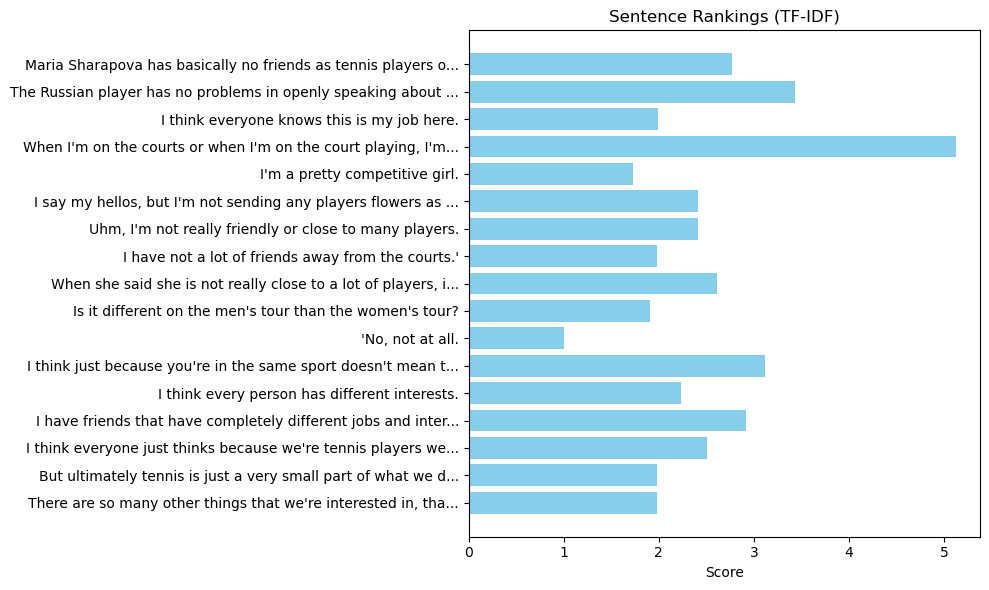

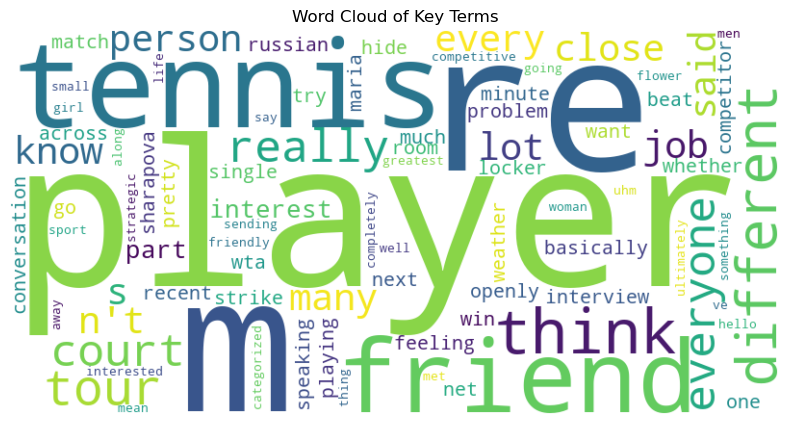

In [10]:
# sentence rankings
def visualize_sentence_rankings(sentences, scores, title="Sentence Rankings"):
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sentences)), scores, color='skyblue', align='center')
    plt.yticks(range(len(sentences)), [s[:60] + '...' if len(s) > 60 else s for s in sentences])
    plt.gca().invert_yaxis()  
    plt.xlabel("Score")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# word cloud
def generate_wordcloud(processed_sentences):
    combined_text = " ".join(processed_sentences)
    wordcloud = WordCloud(
        background_color='white',
        width=800,
        height=400
    ).generate(combined_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud of Key Terms")
    plt.show()

# Main function to visualize text insights
def visualize_text_insights(article_id):
    article_row = data[data['article_id'] == article_id]
    if article_row.empty:
        print(f"Article ID {article_id} not found.")
        return
    
    # Extracting text and preprocess
    article_text = article_row.iloc[0]['article_text']
    sentences, processed_sentences = preprocess_text(article_text)
    
    #  TF-IDF scores
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(processed_sentences)
    sentence_scores = np.array(tfidf_matrix.sum(axis=1)).flatten()
    
    print("\nVisualizations:")
    visualize_sentence_rankings(
        sentences, sentence_scores, title="Sentence Rankings (TF-IDF)"
    )
    generate_wordcloud(processed_sentences)

print("Available Article IDs:")
print(data['article_id'].tolist())
selected_article_id = int(input("Enter the Article ID for visualization: "))
visualize_text_insights(selected_article_id)

# With Global Vectors for Word Representation

In [11]:
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics.pairwise import cosine_similarity


# GloVe embeddings
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Sentence to vector (average word vectors)
def sentence_to_vector(sentence, embeddings, dim=50):
    words = word_tokenize(sentence.lower())
    word_vectors = [
        embeddings[word] for word in words if word in embeddings
    ]
    if not word_vectors:  
        return np.zeros(dim)
    return np.mean(word_vectors, axis=0)

# GloVe-based summarization
def summarize_with_glove(article_text, embeddings, dim=50, num_sentences=5):
    sentences = sent_tokenize(article_text)
    
    
    sentence_vectors = [
        sentence_to_vector(sentence, embeddings, dim)
        for sentence in sentences
    ]
    
    # similarity matrix
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
    for i in range(len(sentences)):
        for j in range(len(sentences)):
            if i != j:
                similarity_matrix[i][j] = cosine_similarity(
                    sentence_vectors[i].reshape(1, -1),
                    sentence_vectors[j].reshape(1, -1)
                )[0, 0]
    
    
    nx_graph = nx.from_numpy_array(similarity_matrix)
    scores = nx.pagerank(nx_graph)
    ranked_sentences = sorted(
        ((scores[i], s) for i, s in enumerate(sentences)), reverse=True
    )
    
    
    summary = [sentence for _, sentence in ranked_sentences[:num_sentences]]
    return " ".join(summary)


In [12]:
def summarize_article_with_glove_dynamic(embeddings, dim=50, num_sentences=3):
    print("Available Article IDs:")
    print(data['article_id'].tolist())
    article_id = int(input("Enter the Article ID to summarize: "))
    
    
    article_row = data[data['article_id'] == article_id]
    if article_row.empty:
        print(f"Article ID {article_id} not found.")
        return
    
    article_text = article_row.iloc[0]['article_text']
    summary = summarize_with_glove(article_text, embeddings, dim, num_sentences)
    
    print(f"\nSummary for Article ID {article_id}:\n")
    print(summary)

# Load GloVe embeddings
glove_file_path = "glove.6B\glove.6B.100d.txt" 
embeddings = load_glove_embeddings(glove_file_path)

summarize_article_with_glove_dynamic(embeddings, dim=50, num_sentences=3)


Available Article IDs:
[1, 2, 3, 4, 5, 6, 7, 8]
Enter the Article ID to summarize: 1

Summary for Article ID 1:

I think just because you're in the same sport doesn't mean that you have to be friends with everyone just because you're categorized, you're a tennis player, so you're going to get along with tennis players. When I'm on the courts or when I'm on the court playing, I'm a competitor and I want to beat every single person whether they're in the locker room or across the net.So I'm not the one to strike up a conversation about the weather and know that in the next few minutes I have to go and try to win a tennis match. But ultimately tennis is just a very small part of what we do.
